In [1]:
import pandas as pd
import seaborn as sns
import folium
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

In [2]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.3)

# Read the dataset

Source: 

 - [Kaggle](https://www.kaggle.com/chetanism/foursquare-nyc-and-tokyo-checkin-dataset/version/2)
 - [yangdingqi](https://sites.google.com/site/yangdingqi/home/foursquare-dataset)

In [3]:
checkins_df = pd.read_csv("../data/dataset_TSMC2014_NYC.csv")

In [4]:
restaurant_categories = pd.read_csv("../data/restaurants.txt", header=None)
restaurant_categories.columns = ["venueCategory"]

In [125]:
category_id_to_name = checkins_df.drop_duplicates(subset=["venueCategory"])[["venueCategoryId", "venueCategory"]]

In [136]:
# fix category duplicates (same names but different ids)
checkins_df = checkins_df\
    .merge(category_id_to_name, on="venueCategory")\
    .drop("venueCategoryId_x", axis=1)\
    .rename({"venueCategoryId_y": "venueCategoryId"},
            axis=1)

# Exploratory data analysis

## Overall dataset

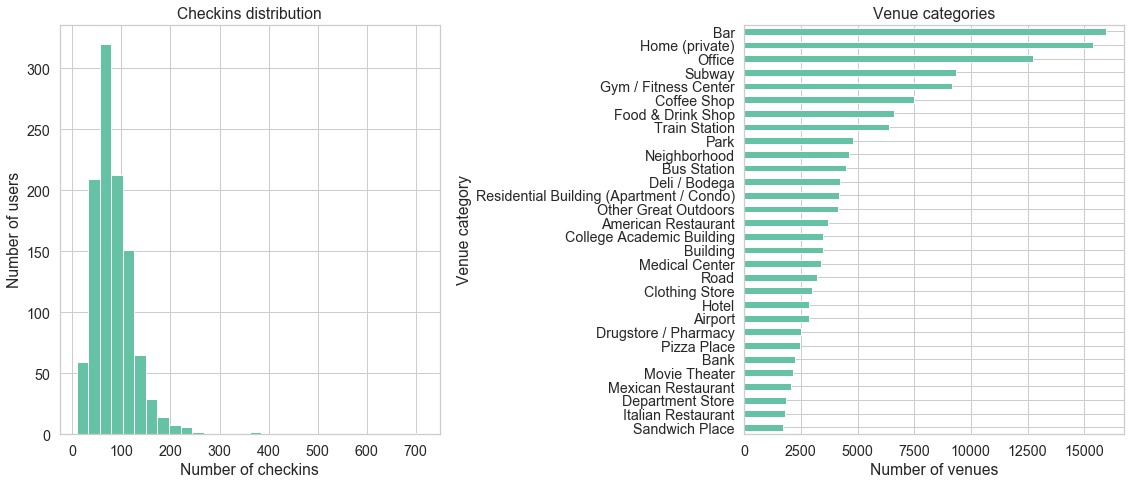

In [137]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

# Checkins distribution
ax = axs[0]

checkins_df\
    .groupby("userId")["venueId"]\
    .nunique()\
    .plot\
    .hist(bins=30,
          ax=ax)

ax.set_xlabel("Number of checkins")
ax.set_ylabel("Number of users")
ax.set_title("Checkins distribution")

# Checkins distribution
ax = axs[1]
checkins_df["venueCategory"]\
    .value_counts()\
    .head(30)\
    .sort_values()\
    .plot(kind="barh", 
          ax=ax)

ax.set_xlabel("Number of venues")
ax.set_ylabel("Venue category")
ax.set_title("Venue categories")

plt.tight_layout()
plt.show()

## Restaurants only

In [138]:
checkins_restaurants_df = checkins_df.merge(restaurant_categories)

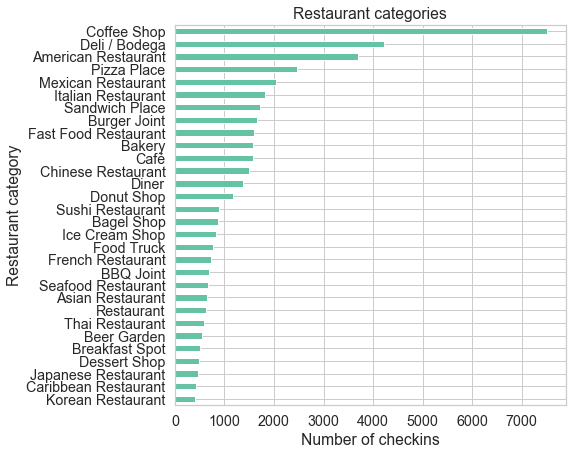

In [139]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

checkins_restaurants_df["venueCategory"]\
    .value_counts()\
    .head(30)\
    .sort_values()\
    .plot(kind="barh", 
          ax=ax)

ax.set_xlabel("Number of checkins")
ax.set_ylabel("Restaurant category")
ax.set_title("Restaurant categories")

plt.show()

In [140]:
top_categories = checkins_restaurants_df["venueCategory"].value_counts().head(10).index
checkins_restaurants_df = checkins_restaurants_df.loc[checkins_restaurants_df["venueCategory"].isin(top_categories)]

## Map 

In [141]:
checkins_home_df = checkins_df.loc[checkins_df["venueCategory"] == "Home (private)"]

In [142]:
m = folium.Map(
    location=[40.7128, -74.0060],
    zoom_start=11,
    min_zoom=11,
    max_zoom=15
)

# Home
for _, row in checkins_home_df.head(100).iterrows():
    marker = folium.Marker(
        location=[row.latitude, row.longitude],
        icon=folium.Icon(
            icon="fa-home",
            prefix="fa"
        )
    )
    
    marker.add_to(m)
    
# Restaurants
for _, row in checkins_restaurants_df.sample(100).iterrows():
    marker = folium.Marker(
        location=[row.latitude, row.longitude],
        tooltip=row.venueCategory,
        icon=folium.Icon(
            icon="fa-cutlery",
            prefix="fa",
            color="red"
        )
    )
    
    marker.add_to(m)

In [143]:
m

# Feature space

## Creation

In [144]:
corpus = checkins_restaurants_df.groupby("userId")["venueCategoryId"].apply(lambda r: " ".join(list(r))).tolist()

In [145]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

assert X.shape == (
    checkins_restaurants_df["userId"].nunique(),
    checkins_restaurants_df["venueCategoryId"].nunique()
)

In [146]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    # ("pca", PCA(n_components=40)),
    ("tsne", TSNE())
])

X_reduced = pipeline.fit_transform(X.todense())

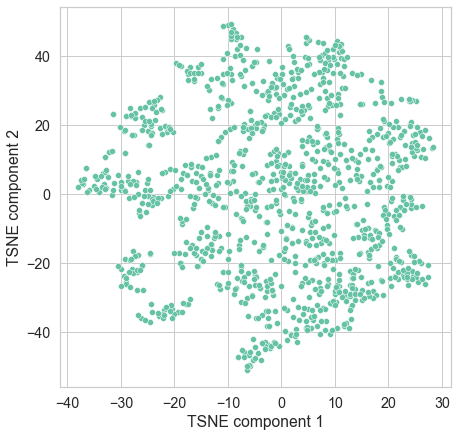

In [147]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    ax=ax
)

ax.set_xlabel("TSNE component 1")
ax.set_ylabel("TSNE component 2")

plt.show()

## Debugging

In [151]:
nearest_neighbors = NearestNeighbors(n_neighbors=10).fit(X_reduced)

In [152]:
def draw_user_radar(user_index):
    user_profile = pd.DataFrame(
        dict(
            venueCategoryId=vectorizer.get_feature_names(),
            n_checkins=X[user_index].todense().tolist()[0]
        )
    )

    user_profile = user_profile.merge(category_id_to_name).sort_values("venueCategory")

    ax = go.Scatterpolar(
        r=user_profile["n_checkins"],
        theta=user_profile["venueCategory"],
        fill="toself",
        name="User {0}".format(user_index),
        opacity=.6
    )
    
    return ax

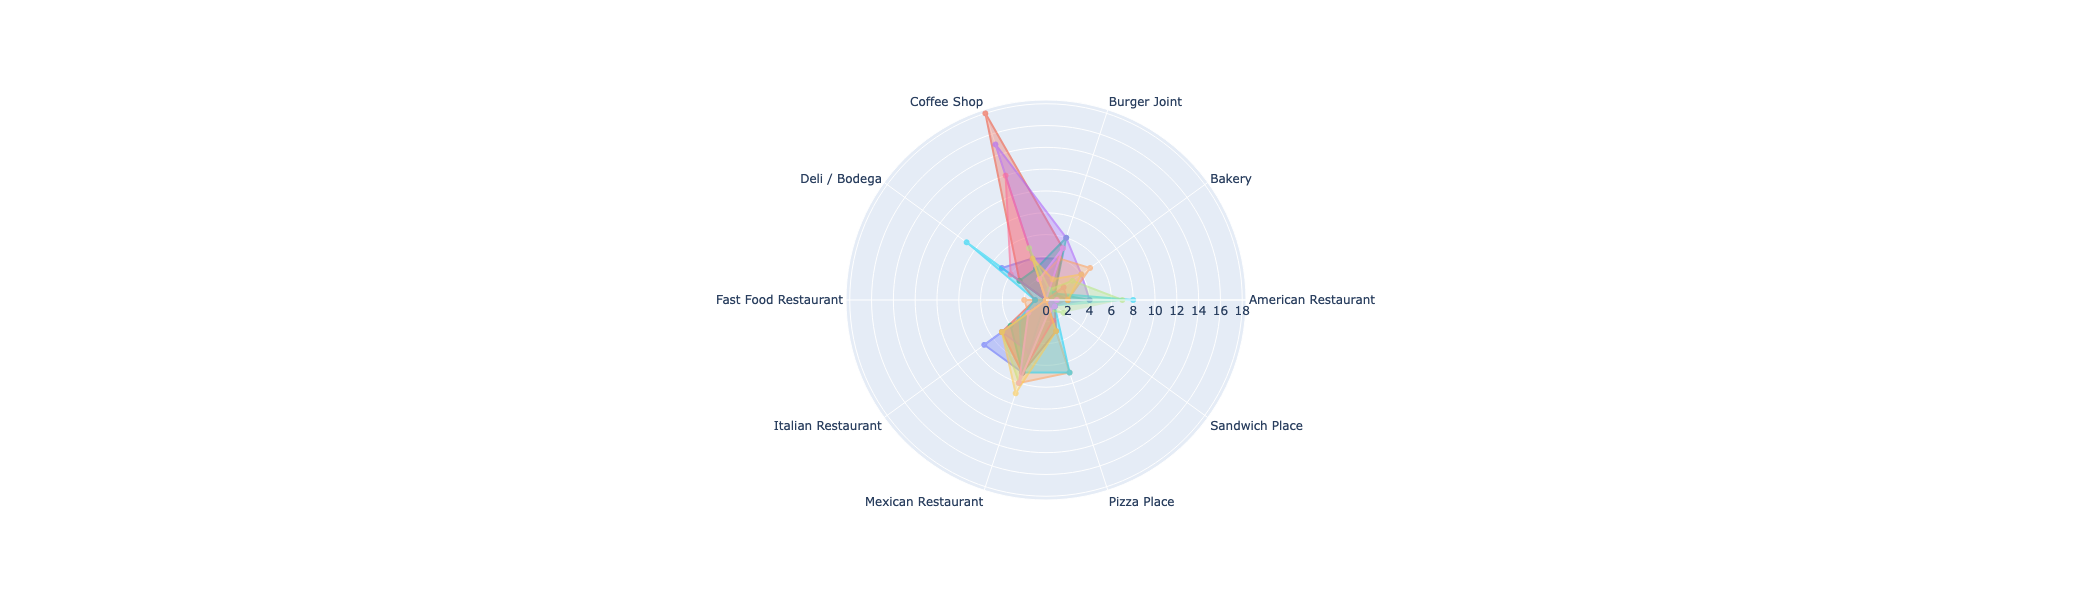

In [153]:
distances, indices = nearest_neighbors.kneighbors(X_reduced[[9]])

fig = go.Figure()

for user_index in indices[0]:
    fig.add_trace(draw_user_radar(user_index))
    
fig.update_layout(
    height=600,
    width=800,
    margin=dict(
        l=200,
        r=200,
        b=100,
        t=100,
        pad=4
    ),
    showlegend=False
)